In [41]:
import spatialdata
import spatialdata_plot
import napari
import napari_spatialdata

import sopa.segmentation
import sopa.io
from sopa._sdata import get_spatial_image

import matplotlib.pyplot as plt
import math
import numpy as np
import xarray
import xarray as xr

import skimage.exposure
from spatialdata.transformations import Identity

import geopandas as gpd
import numpy as np
import rasterio
from rasterio.features import rasterize
from shapely.geometry import Polygon, mapping
from skimage.draw import polygon_perimeter

In [3]:
path_to_image = "../data/991_subset.ome.tif"
sdata = sopa.io.ome_tif(path_to_image)

INFO     `dims` is specified redundantly: found also inside `data`.                                                


In [58]:
def calculate_quantile(sdata, key: str, channels: list, quantile_value: float = 0.9, return_ArrayData: bool = False, min_max_scaling_quantiles=[0.5, 0.995]):

    image = sdata.images[key]['scale0'].image
    assert type(image) == xarray.core.dataarray.DataArray, 'Image is not a xarray DataArray'
    selected_channels_image = image.sel(c=channels)

    def scaling(data_array, min_max_quantiles=[0.5, 0.995]):
        data_array = data_array.chunk(dict(x=-1, y=-1))
        q_min = data_array.quantile(min_max_quantiles[0], dim=('x', 'y')).values
        q_max = data_array.quantile(min_max_quantiles[1], dim=('x', 'y')).values
        clipped_channel = data_array.clip(min=q_min, max=q_max)
        rescaled_channel = (clipped_channel - q_min) / (q_max - q_min) * 255.0
        rescaled_channel_8bit = rescaled_channel.astype(np.uint8)
        return rescaled_channel_8bit

    data_arrays = [selected_channels_image.sel(c=c) for c in channels]
    scaled_data_arrays = [scaling(data_array, min_max_scaling_quantiles) for data_array in data_arrays]
    concat_data_array = xarray.concat(scaled_data_arrays, dim='c').chunk({'c': -1})
    quantile_projection = concat_data_array.quantile(quantile_value, dim='c').astype(np.uint8)
    quantile_projection_expanded = quantile_projection.expand_dims(dim='c', axis=0)

    if return_ArrayData:
        return quantile_projection_expanded
    else:
        sdata.images[f'{key}_q{int(quantile_value*100)}_projection'] = spatialdata.models.Image2DModel.parse(data=quantile_projection_expanded)
        return sdata
    
def quantiles_nuclear_membrane(sdata, key:str, 
                            nuclear_channels:list=None, 
                            nuclear_quantile:float=0.9,
                            nuclear_min_max_quantiles:list=[0.5, 0.995],
                            membrane_channels:list=None,
                            membrane_quantile:float=0.9,
                            membrane_min_max_quantiles:list=[0.5, 0.995]):

    nuclear_ArrayData = calculate_quantile(sdata, key, nuclear_channels, nuclear_quantile, return_ArrayData=True, min_max_scaling_quantiles=nuclear_min_max_quantiles)
    print(nuclear_ArrayData.dtype)
    membrane_ArrayData = calculate_quantile(sdata, key, membrane_channels, membrane_quantile, return_ArrayData=True, min_max_scaling_quantiles=membrane_min_max_quantiles)
    print(membrane_ArrayData.dtype)

    concatenated_array = spatialdata.models.Image2DModel.parse(
        xarray.concat([nuclear_ArrayData, membrane_ArrayData], dim='c'), transformations={"pixels":Identity()}
        )
    
    name = f'{key}_n{int(nuclear_quantile*100)}_m{int(membrane_quantile*100)}_mmm{str(membrane_min_max_quantiles[0]).replace(".","")}_proj'

    sdata.images[name] = concatenated_array
    sdata.images[name] = sdata.images[name].assign_coords(c=['Nuclei', 'Membranes'])
    return sdata

In [59]:
sdata = quantiles_nuclear_membrane(sdata=sdata, 
                                key='991_subset',
                                nuclear_channels=['DAPI_bg', 'DAPI_1'],
                                nuclear_quantile=0.9,
                                nuclear_min_max_quantiles=[0.5, 0.995],
                                membrane_channels=['Vimentin', 'CD3e', 'panCK', 'CD8', 'COL1A1', 'CD20', 'CD68'],
                                membrane_quantile=0.8,
                                membrane_min_max_quantiles=[0.5, 0.995])

uint8
uint8


/opt/homebrew/Caskroom/mambaforge/base/envs/SOPA3/lib/python3.10/site-packages/spatialdata/_core/_elements.py:62: UserWarning: Key `991_subset_n90_m80_mmm05_proj` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/opt/homebrew/Caskroom/mambaforge/base/envs/SOPA3/lib/python3.10/site-packages/spatialdata/_core/_elements.py:62: UserWarning: Key `991_subset_n90_m80_mmm05_proj` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


In [62]:
sdata.write('../zarrs/20240718_991_subset.zarr')

INFO     The Zarr backing store has been changed from ../zarrs/20240718_991_subset_memseg.zarr the new file path:  
         ../zarrs/20240718_991_subset.zarr                                                                         


In [25]:
sdata

SpatialData object, with associated Zarr store: /Users/jnimoca/Jose_BI/P26_SOPA_seg/zarrs/20240718_991_subset_memseg.zarr
├── Images
│     ├── '991_subset': DataTree[cyx] (15, 8000, 8000), (15, 4000, 4000), (15, 2000, 2000), (15, 1000, 1000), (15, 500, 500)
│     └── '991_subset_n90_m80_mmm05_proj': DataArray[cyx] (2, 8000, 8000)
└── Shapes
      └── 'sopa_patches': GeoDataFrame shape: (64, 3) (2D shapes)
with coordinate systems:
    ▸ 'pixels', with elements:
        991_subset (Images), 991_subset_n90_m80_mmm05_proj (Images), sopa_patches (Shapes)

In [8]:
patches = sopa.segmentation.Patches2D(sdata, element_name="991_subset", patch_width=1200, patch_overlap=100)
patches.write()

[INFO] (sopa.patches.patches) 64 patches were saved in sdata['sopa_patches']


,geometry,bboxes,ilocs
0,"POLYGON ((1200 0, 1200 1200, 0 1200, 0 0, 1200...","[0, 0, 1200, 1200]","[0, 0]"
1,"POLYGON ((2300 0, 2300 1200, 1100 1200, 1100 0...","[1100, 0, 2300, 1200]","[1, 0]"
2,"POLYGON ((3400 0, 3400 1200, 2200 1200, 2200 0...","[2200, 0, 3400, 1200]","[2, 0]"
3,"POLYGON ((4500 0, 4500 1200, 3300 1200, 3300 0...","[3300, 0, 4500, 1200]","[3, 0]"
4,"POLYGON ((5600 0, 5600 1200, 4400 1200, 4400 0...","[4400, 0, 5600, 1200]","[4, 0]"
...,...,...,...
59,"POLYGON ((4500 7700, 4500 8900, 3300 8900, 330...","[3300, 7700, 4500, 8900]","[3, 7]"
60,"POLYGON ((5600 7700, 5600 8900, 4400 8900, 440...","[4400, 7700, 5600, 8900]","[4, 7]"
61,"POLYGON ((6700 7700, 6700 8900, 5500 8900, 550...","[5500, 7700, 6700, 8900]","[5, 7]"
62,"POLYGON ((7800 7700, 7800 8900, 6600 8900, 660...","[6600, 7700, 7800, 8900]","[6, 7]"


In [12]:
sdata.images['991_subset_n90_m80_mmm05_proj'].dtype

dtype('float64')

In [26]:
method = sopa.segmentation.methods.cellpose_patch(diameter=25, channels=["Membranes", "Nuclei"], flow_threshold=0.6, cellprob_threshold=-6, model_type="cyto3")
segmentation = sopa.segmentation.StainingSegmentation(sdata, method, image_key='991_subset_n90_m80_mmm05_proj', channels=["Membranes", "Nuclei"], min_area=250)
cellpose_temp_dir = "../zarrs/20240718_991_subset_memseg.zarr/.sopa_cache/cellpose"

In [27]:
segmentation.write_patches_cells(cellpose_temp_dir)

[WARNING] (sopa.segmentation.stainings) Running segmentation in a sequential manner. This is not recommended on large images because it can be extremely slow (see https://github.com/gustaveroussy/sopa/discussions/36 for more details)
Run all patches: 100%|██████████| 64/64 [26:05<00:00, 24.47s/it]


In [30]:
cells = sopa.segmentation.StainingSegmentation.read_patches_cells(cellpose_temp_dir)

Reading patches: 100%|██████████| 64/64 [00:00<00:00, 439.47it/s]
[INFO] (sopa.segmentation.stainings) Found 22300 total cells


In [31]:
cells = sopa.segmentation.shapes.solve_conflicts(cells)

Resolving conflicts: 100%|██████████| 15200/15200 [00:01<00:00, 8890.99it/s]


In [32]:
sopa.segmentation.StainingSegmentation.add_shapes(sdata, cells, image_key="991_subset", shapes_key="cyto3_membrane_masks")

[INFO] (sopa.segmentation.stainings) Added 18876 cell boundaries in sdata['cyto3_membrane_masks']


In [33]:
sdata

SpatialData object, with associated Zarr store: /Users/jnimoca/Jose_BI/P26_SOPA_seg/zarrs/20240718_991_subset_memseg.zarr
├── Images
│     ├── '991_subset': DataTree[cyx] (15, 8000, 8000), (15, 4000, 4000), (15, 2000, 2000), (15, 1000, 1000), (15, 500, 500)
│     └── '991_subset_n90_m80_mmm05_proj': DataArray[cyx] (2, 8000, 8000)
└── Shapes
      ├── 'cyto3_membrane_masks': GeoDataFrame shape: (18876, 1) (2D shapes)
      └── 'sopa_patches': GeoDataFrame shape: (64, 3) (2D shapes)
with coordinate systems:
    ▸ 'pixels', with elements:
        991_subset (Images), 991_subset_n90_m80_mmm05_proj (Images), cyto3_membrane_masks (Shapes), sopa_patches (Shapes)

In [34]:
napari_spatialdata.Interactive(sdata)

2024-07-18 16:12:54.774 | INFO     | napari_spatialdata._view:_on_layer_update:327 - Updating layer.
2024-07-18 16:12:54.775 | INFO     | napari_spatialdata._view:_on_layer_update:327 - Updating layer.
2024-07-18 16:13:27.011 | INFO     | napari_spatialdata._view:_on_layer_update:327 - Updating layer.
2024-07-18 16:13:27.012 | INFO     | napari_spatialdata._view:_on_layer_update:327 - Updating layer.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2024-07-18 16:15:44.346 | INFO     | napari_spatialdata._view:_on_layer_update:327 - Updating layer.
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/mambaforge/base/envs/SOPA3/lib/python3.10/site-packages/app_model/backends/qt/_qaction.py", line 55, in _on_triggered
    self._app.commands.execute_command(self._command_id).result()
  File "/opt/homebrew/Caskroom/mambaforge/base/envs/SOPA3/lib/python3.10/site-packages/app_model/registries/_commands_reg.py", line 245, in execute_

## Load shapes as an image in spatialdata

In [35]:
sdata

SpatialData object, with associated Zarr store: /Users/jnimoca/Jose_BI/P26_SOPA_seg/zarrs/20240718_991_subset_memseg.zarr
├── Images
│     ├── '991_subset': DataTree[cyx] (15, 8000, 8000), (15, 4000, 4000), (15, 2000, 2000), (15, 1000, 1000), (15, 500, 500)
│     └── '991_subset_n90_m80_mmm05_proj': DataArray[cyx] (2, 8000, 8000)
└── Shapes
      ├── 'cyto3_membrane_masks': GeoDataFrame shape: (18876, 1) (2D shapes)
      └── 'sopa_patches': GeoDataFrame shape: (64, 3) (2D shapes)
with coordinate systems:
    ▸ 'pixels', with elements:
        991_subset (Images), 991_subset_n90_m80_mmm05_proj (Images), cyto3_membrane_masks (Shapes), sopa_patches (Shapes)

In [57]:
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.features import rasterize
from shapely.geometry import Polygon, mapping
from skimage.draw import polygon_perimeter

# Load your GeoDataFrame
gdf = sdata.shapes['cyto3_membrane_masks']

# Define the raster size and transformation (modify as needed)
width, height = 8000, 8000  # Set your desired raster size
transform = rasterio.transform.from_bounds(*gdf.total_bounds, width, height)

# Initialize an empty raster
raster = np.zeros((height, width), dtype=np.uint16)

# Function to rasterize polygon perimeters
def rasterize_perimeters(raster, polygons, transform, intensity=10000):
    for poly in polygons:
        if isinstance(poly, Polygon):
            exterior_coords = np.array(poly.exterior.coords)
            rows, cols = rasterio.transform.rowcol(transform, exterior_coords[:, 0], exterior_coords[:, 1])
            
            # Flip the rows on the y-axis
            rows = raster.shape[0] - 1 - np.array(rows)

            rr, cc = polygon_perimeter(rows, cols, shape=raster.shape)
            raster[rr, cc] = intensity
    return raster

# Extract polygons from GeoDataFrame
polygons = gdf.geometry

# Rasterize the perimeters
raster = rasterize_perimeters(raster, polygons, transform)

# Save the raster to a file
with rasterio.open(
    'rasterized_perimeters.tif',
    'w',
    driver='GTiff',
    height=raster.shape[0],
    width=raster.shape[1],
    count=1,
    dtype=raster.dtype,
    crs=gdf.crs,
    transform=transform,
) as dst:
    dst.write(raster, 1)

print("Rasterization complete. The raster is saved as 'rasterized_perimeters.tif'.")

Rasterization complete. The raster is saved as 'rasterized_perimeters.tif'.


In [88]:
raster.shape

(1, 8000, 8000)

In [87]:
type(raster)

numpy.ndarray

In [86]:
#add c dimension to raster
raster = raster[np.newaxis, :, :]

In [89]:
image_model = spatialdata.models.Image2DModel.parse(raster, dims=['c','y','x'], transformations={"pixels":Identity()})

In [90]:
sdata.images['shapes'] = image_model

In [91]:
sdata

SpatialData object, with associated Zarr store: /Users/jnimoca/Jose_BI/P26_SOPA_seg/zarrs/20240718_991_subset.zarr
├── Images
│     ├── '991_subset': DataTree[cyx] (15, 8000, 8000), (15, 4000, 4000), (15, 2000, 2000), (15, 1000, 1000), (15, 500, 500)
│     ├── '991_subset_n90_m80_mmm05_proj': DataArray[cyx] (2, 8000, 8000)
│     └── 'shapes': DataArray[cyx] (1, 8000, 8000)
└── Shapes
      ├── 'cyto3_membrane_masks': GeoDataFrame shape: (18876, 1) (2D shapes)
      └── 'sopa_patches': GeoDataFrame shape: (64, 3) (2D shapes)
with coordinate systems:
    ▸ 'pixels', with elements:
        991_subset (Images), 991_subset_n90_m80_mmm05_proj (Images), shapes (Images), cyto3_membrane_masks (Shapes), sopa_patches (Shapes)
with the following elements not in the Zarr store:
    ▸ shapes (Images)

In [109]:
crop = [2000, 2000, 3000, 3000]
cropped_sdata = sdata.query.bounding_box(
            axes=["x", "y"],
            min_coordinate=[crop[0], crop[1]],
            max_coordinate=[crop[2], crop[3]],
            target_coordinate_system='pixels'
            )

In [93]:
sdata.images['shapes']

<xarray.DataArray 'image' (c: 1, y: 8000, x: 8000)> Size: 128MB
dask.array<array, shape=(1, 8000, 8000), dtype=uint16, chunksize=(1, 8000, 8000), chunktype=numpy.ndarray>
Coordinates:
  * c        (c) int64 8B 0
  * y        (y) float64 64kB 0.5 1.5 2.5 3.5 ... 7.998e+03 7.998e+03 8e+03
  * x        (x) float64 64kB 0.5 1.5 2.5 3.5 ... 7.998e+03 7.998e+03 8e+03
Attributes:
    transform:  {'pixels': Identity }

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00392156862745098..1.6705882352941175].


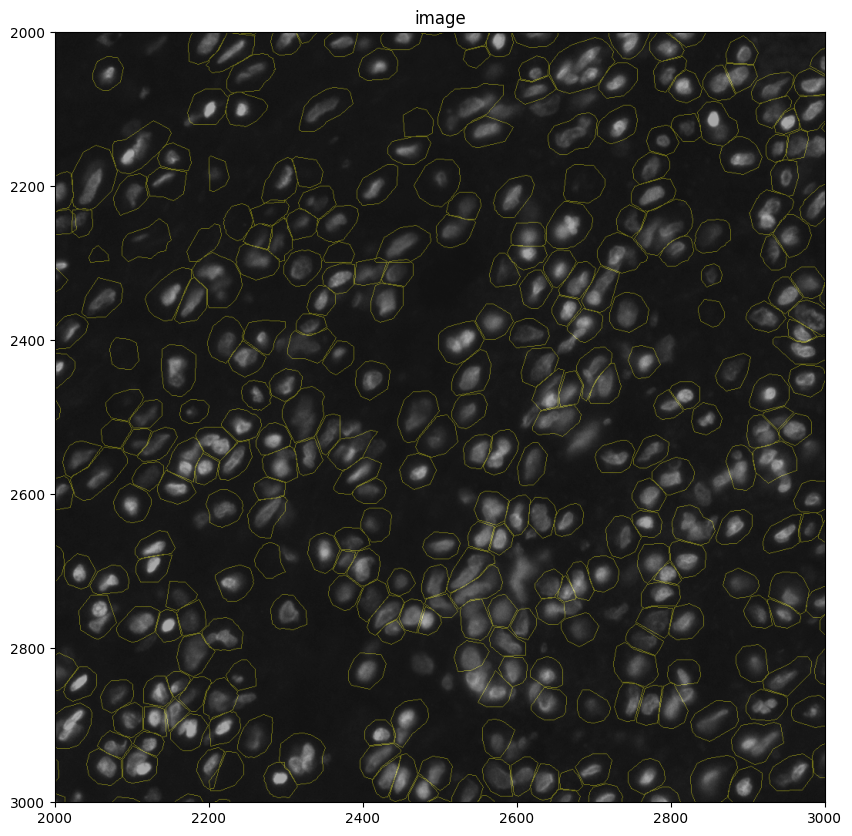

In [98]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

#plot first image
cropped_sdata.pl.render_images(element="shapes", alpha=0.85, channel=["0"], palette=['yellow']).pl.show(ax=ax, title="shapes")
cropped_sdata.pl.render_images(element="991_subset", alpha=0.6, channel=["DAPI_bg", "DAPI_1"], palette=['white', 'white']).pl.show(ax=ax, title="image")

In [99]:
sdata

SpatialData object, with associated Zarr store: /Users/jnimoca/Jose_BI/P26_SOPA_seg/zarrs/20240718_991_subset.zarr
├── Images
│     ├── '991_subset': DataTree[cyx] (15, 8000, 8000), (15, 4000, 4000), (15, 2000, 2000), (15, 1000, 1000), (15, 500, 500)
│     ├── '991_subset_n90_m80_mmm05_proj': DataArray[cyx] (2, 8000, 8000)
│     └── 'shapes': DataArray[cyx] (1, 8000, 8000)
└── Shapes
      ├── 'cyto3_membrane_masks': GeoDataFrame shape: (18876, 1) (2D shapes)
      └── 'sopa_patches': GeoDataFrame shape: (64, 3) (2D shapes)
with coordinate systems:
    ▸ 'pixels', with elements:
        991_subset (Images), 991_subset_n90_m80_mmm05_proj (Images), shapes (Images), cyto3_membrane_masks (Shapes), sopa_patches (Shapes)
with the following elements not in the Zarr store:
    ▸ shapes (Images)

In [104]:
raster = spatialdata.rasterize(data=sdata.shapes['cyto3_membrane_masks'], 
                    axes=['x','y'], 
                    min_coordinate=[0,0], 
                    max_coordinate=[8000,8000], 
                    target_coordinate_system='pixels',
                    target_width=8000)

In [105]:
sdata.images['shapes_2'] = raster

In [106]:
sdata

SpatialData object, with associated Zarr store: /Users/jnimoca/Jose_BI/P26_SOPA_seg/zarrs/20240718_991_subset.zarr
├── Images
│     ├── '991_subset': DataTree[cyx] (15, 8000, 8000), (15, 4000, 4000), (15, 2000, 2000), (15, 1000, 1000), (15, 500, 500)
│     ├── '991_subset_n90_m80_mmm05_proj': DataArray[cyx] (2, 8000, 8000)
│     ├── 'shapes': DataArray[cyx] (1, 8000, 8000)
│     └── 'shapes_2': DataArray[cyx] (1, 8000, 8000)
└── Shapes
      ├── 'cyto3_membrane_masks': GeoDataFrame shape: (18876, 1) (2D shapes)
      └── 'sopa_patches': GeoDataFrame shape: (64, 3) (2D shapes)
with coordinate systems:
    ▸ 'pixels', with elements:
        991_subset (Images), 991_subset_n90_m80_mmm05_proj (Images), shapes (Images), shapes_2 (Images), cyto3_membrane_masks (Shapes), sopa_patches (Shapes)
with the following elements not in the Zarr store:
    ▸ shapes_2 (Images)
    ▸ shapes (Images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00392156862745098..1.6705882352941175].


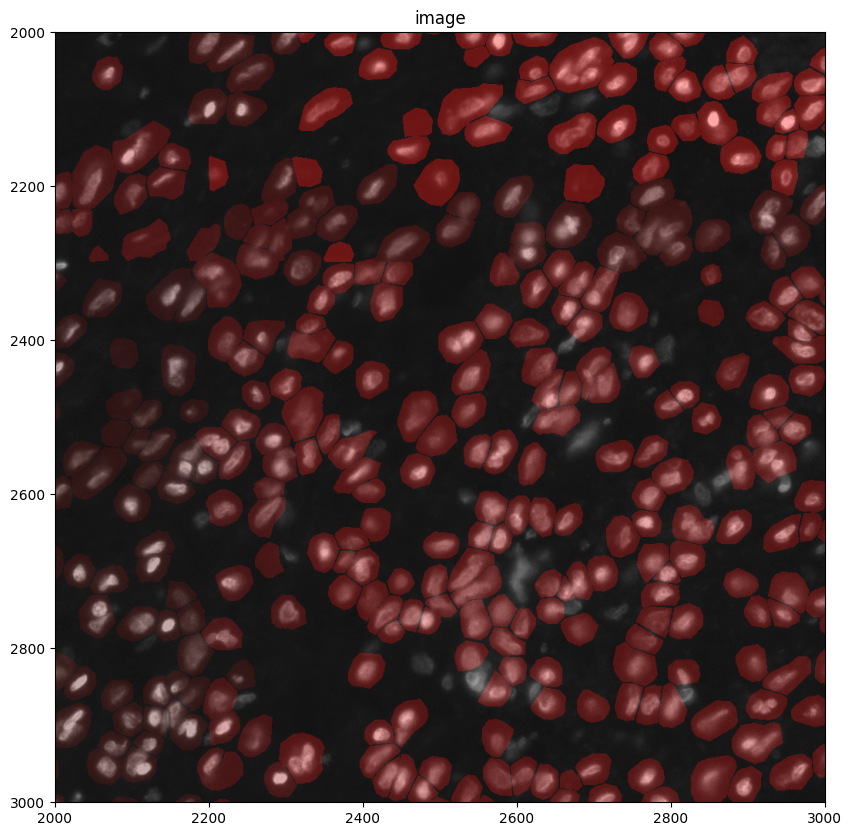

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

#plot first image
# cropped_sdata.pl.render_images(element="shapes", alpha=0.85, channel=["0"], palette=['yellow']).pl.show(ax=ax, title="shapes")
cropped_sdata.pl.render_images(element="shapes_2", alpha=0.85, channel=["0"], palette=['red']).pl.show(ax=ax, title="shapes")
cropped_sdata.pl.render_images(element="991_subset", alpha=0.6, channel=["DAPI_bg", "DAPI_1"], palette=['white', 'white']).pl.show(ax=ax, title="image")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00392156862745098..1.6705882352941175].


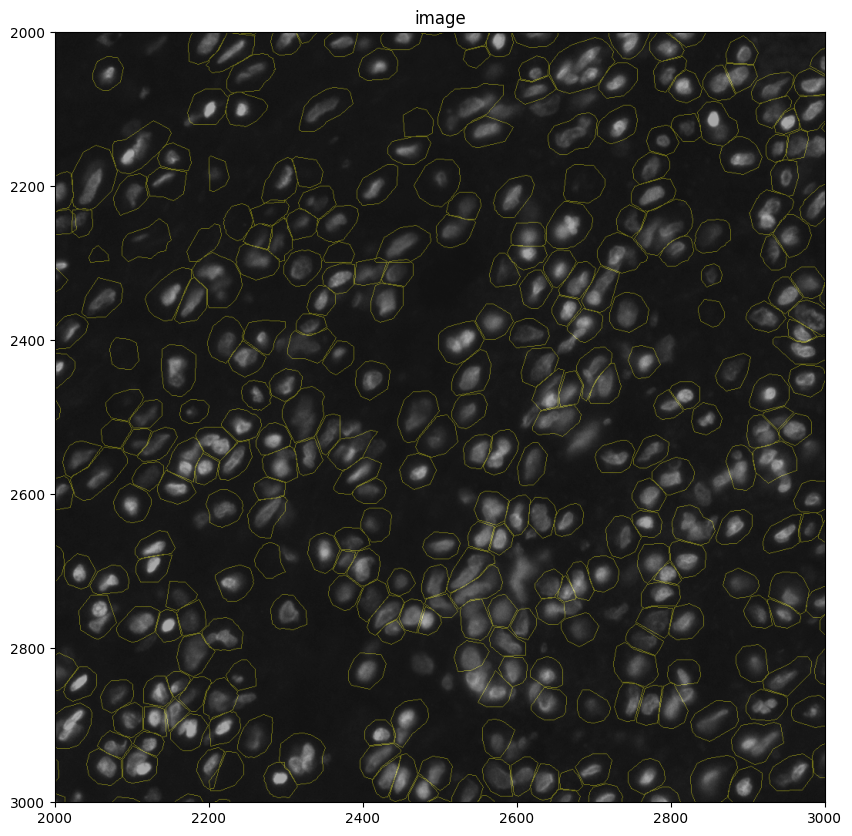

In [112]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

#plot first image
cropped_sdata.pl.render_images(element="shapes", alpha=0.85, channel=["0"], palette=['yellow']).pl.show(ax=ax, title="shapes")
# cropped_sdata.pl.render_images(element="shapes_2", alpha=0.85, channel=["0"], palette=['red']).pl.show(ax=ax, title="shapes")
cropped_sdata.pl.render_images(element="991_subset", alpha=0.6, channel=["DAPI_bg", "DAPI_1"], palette=['white', 'white']).pl.show(ax=ax, title="image")